## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## IMPORT LIBRARIES

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Suppress TensorFlow logging messages
tf.get_logger().setLevel(logging.ERROR)

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## LOAD DATA

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [ ]:

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (13759, 96, 96, 3)
y shape: (13759, 1)


## PLOT DATA

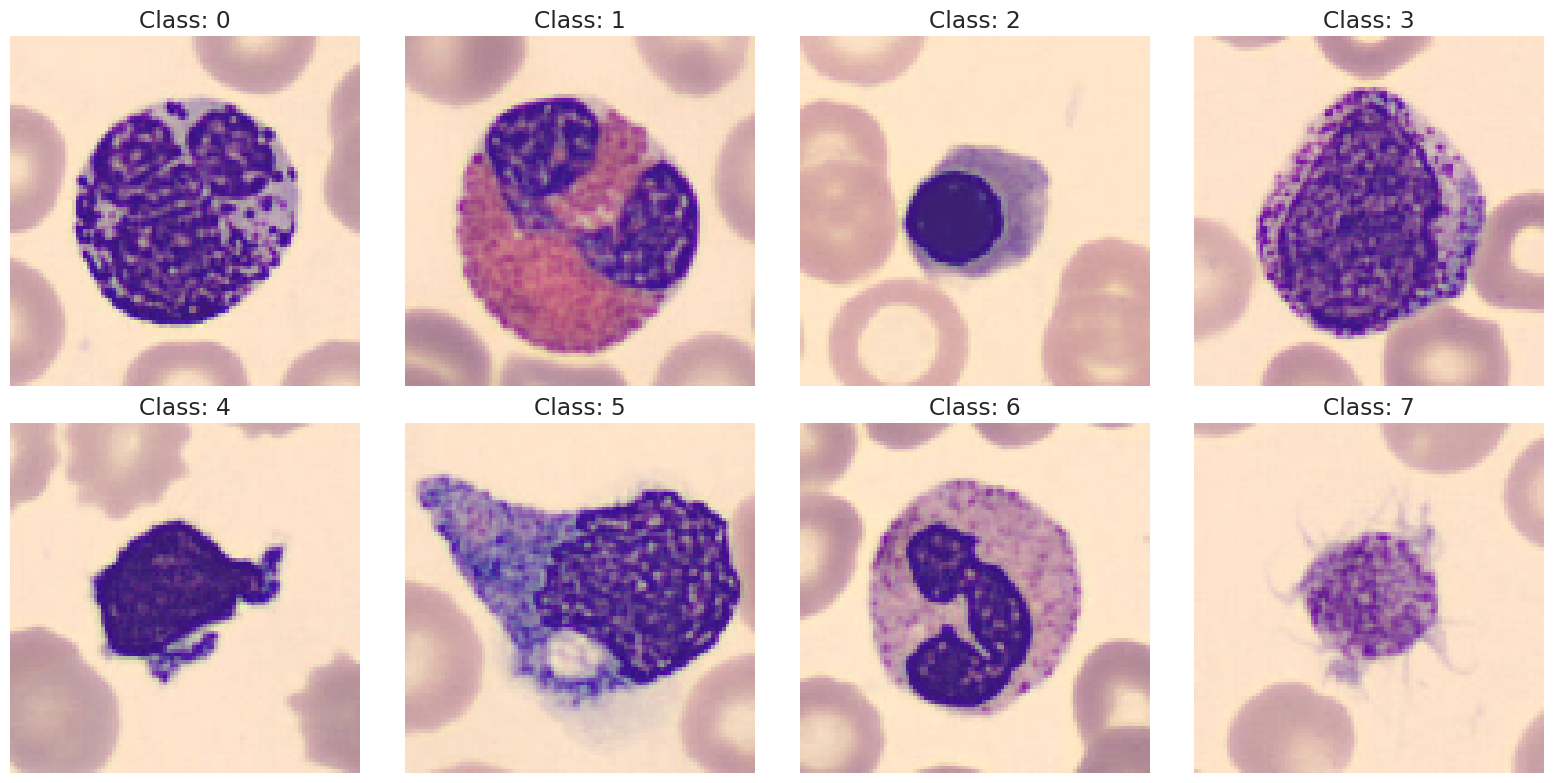

In [ ]:

def plot_random_examples_per_class(X, y):
  """Plots one random example per class from the given data.

  Args:
    X: The input data (images).
    y: The corresponding labels.
  """

  classes = np.unique(y)
  num_classes = len(classes)
  examples_per_class = {}

  for class_label in classes:
    indices = np.where(y == class_label)[0]
    random_index = random.choice(indices)
    examples_per_class[class_label] = X[random_index]

  plt.figure(figsize=(16, 8))
  gs = gridspec.GridSpec(2, 4)

  for i, (class_label, example) in enumerate(examples_per_class.items()):
    ax = plt.subplot(gs[i // 4, i % 4])
    ax.imshow(example)
    ax.set_title(f"Class: {class_label}")
    ax.axis('off')

  plt.tight_layout()
  plt.show()

plot_random_examples_per_class(X, y)

## FIND OUTLIERS (DOUBLE)



In [ ]:

import hashlib

def create_image_hash_dictionary(X):
  """Creates a dictionary mapping image hashes to their counts and indices.

  Args:
    X: The input data (images).

  Returns:
    A dictionary where keys are image hashes and values are a tuple containing
    the count and a list of indices where the image is present.
  """
  image_hash_dict = {}
  for i, image in enumerate(X):
    image_hash = hashlib.md5(image.tobytes()).hexdigest()
    if image_hash in image_hash_dict:
      image_hash_dict[image_hash][0] += 1
      image_hash_dict[image_hash][1].append(i)
    else:
      image_hash_dict[image_hash] = [1, [i]]
  return image_hash_dict

image_hash_dictionary = create_image_hash_dictionary(X)

In [ ]:

for image_hash, (count, indices) in image_hash_dictionary.items():
  if count > 1:
    print(f"Image hash: {image_hash}, Count: {count}, Indices: {indices}")

Image hash: d5dd027c53115329e3ae38255636b002, Count: 2, Indices: [120, 4761]
Image hash: 7d886eea58027fdf845dae148f2c58ee, Count: 2, Indices: [810, 11026]
Image hash: 925d5dc55eecab7e2f3c9d83a281634f, Count: 2, Indices: [1074, 3440]
Image hash: 96db0569d5cbdab3bbd527551002138a, Count: 2, Indices: [3052, 11566]
Image hash: f39a51aa0f212ab7288df2aba5fc8a6e, Count: 2, Indices: [3328, 11575]
Image hash: 1e26f78cdf123cb948fdca2aacd18049, Count: 2, Indices: [5466, 11856]
Image hash: d94ef7d729ff6e7ec3c6349c14d602df, Count: 2, Indices: [7953, 10734]
Image hash: 06c86bed6d52d0fd55f12db4a4ad7d1c, Count: 2, Indices: [8117, 9084]
Image hash: 6cf0f392e57a6c16165d9b84c885ff78, Count: 1600, Indices: [11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11983, 11984, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 120

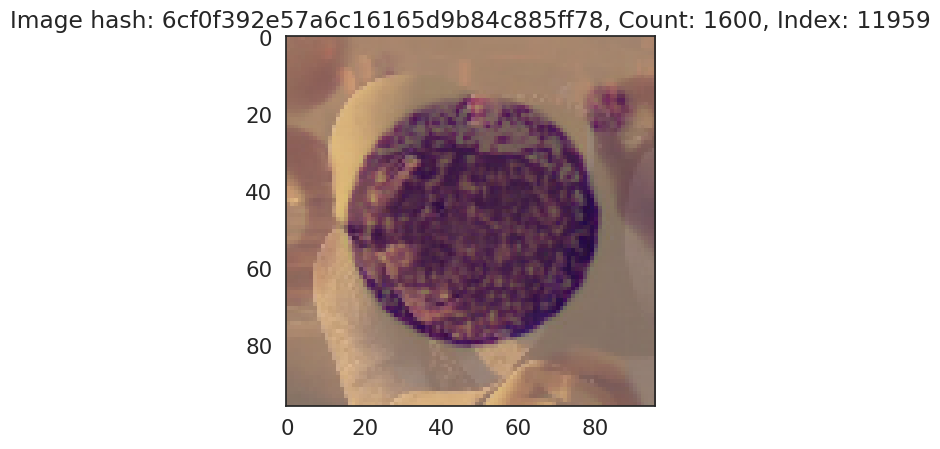

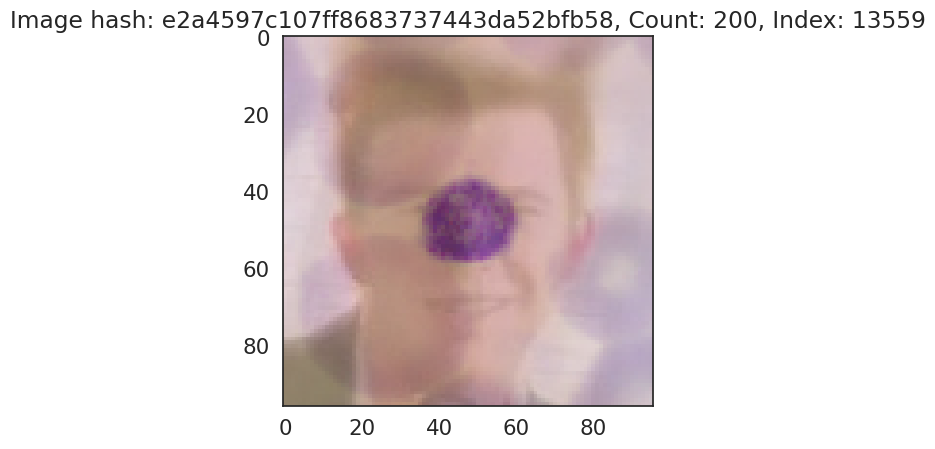

In [ ]:

for image_hash, (count, indices) in image_hash_dictionary.items():
  if count > 2:
    first_index = indices[0]  # Take the first index
    plt.imshow(X[first_index])  # Show the image at the first index
    plt.title(f"Image hash: {image_hash}, Count: {count}, Index: {first_index}")
    plt.show()

In [ ]:

X_new = []
y_new = []

print("X shape:", X.shape)
print("y shape:", y.shape)

for i in range(len(X)):
  image_hash = hashlib.md5(X[i].tobytes()).hexdigest()
  if image_hash not in image_hash_dictionary or image_hash_dictionary[image_hash][0] <= 2:
    X_new.append(X[i])
    y_new.append(y[i])

X_new = np.array(X_new)
y_new = np.array(y_new)

print("X_new shape:", X_new.shape)
print("y_new shape:", y_new.shape)

X shape: (13759, 96, 96, 3)
y shape: (13759, 1)
X_new shape: (11959, 96, 96, 3)
y_new shape: (11959, 1)


## CREATE DATASET

In [ ]:

np.savez_compressed('clean_training_dataset.npz', images=X_new, labels=y_new)